# Check Mock Covariances against Model Covariances

In [1]:
from spore.mock.mock_ps_foregrounds import visibility_covariance, PoissonProcessForegrounds, ClusteredForegroundsOnly, ClusteredForegrounds,PowerLawSourceCounts, CircularGaussian
from spore.model.foregrounds import PointSourceCircularGaussian, CircularGaussianPowerLaw
from spore.measure.power_spec import get_ps_from_cov
from spore.visualise.power_spectra import plot_2D_PS, plot_2D_PS_compare, plot_2D_PS_ratio_diff


import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial, gamma, binom, hermite
import cPickle as pickle
from matplotlib.colors import LogNorm
%matplotlib inline
import matplotlib as mpl
from scipy.interpolate import InterpolatedUnivariateSpline as spline

from powerbox.powerbox import _magnitude_grid
from powerbox import PowerBox, LogNormalPowerBox
from powerbox.dft import fft, ifft,fftfreq
from hankel import SymmetricFourierTransform, HankelTransform

## Poisson-only Structure

### Variances

#### Setup Mocks

In [2]:
def get_cov_poisson(nu, ncells=256, Smin=0.1,Smax=1.0,alpha=4100.,beta=1.59,nu0=150.):
    sc = PowerLawSourceCounts(nu=nu,Smax0=Smax,Smin0=Smin,alpha=alpha,beta = beta)
    beam = CircularGaussian(nu0,nu=nu)

    ppf = PoissonProcessForegrounds(sc,beam,ncells=ncells,seed=1234)
    
    res = [0]*10
    for i in range(10):
        res[i] = visibility_covariance(source_counts=sc,beam_model = beam,ncells=ncells,ret_realisations=False)
        
    return sc,beam,ppf, res

In [3]:
pv = {}
pv['sc'],pv['beam'],pv['ppf'], pv['res'] = get_cov_poisson(1)

/home/steven/anaconda2/lib/python2.7/site-packages/spore-0.0.1-py2.7.egg/spore/mock/mock_ps_foregrounds.py:178: ComplexWarning: Casting complex values to real discards the imaginary part


#### Define Model

In [4]:
pv_model = PointSourceCircularGaussian(pv['sc'],pv['beam'],pv['res'][0][0])

#### Compare

/home/steven/anaconda2/lib/python2.7/site-packages/spore-0.0.1-py2.7.egg/spore/mock/mock_ps_foregrounds.py:159: ComplexWarning: Casting complex values to real discards the imaginary part


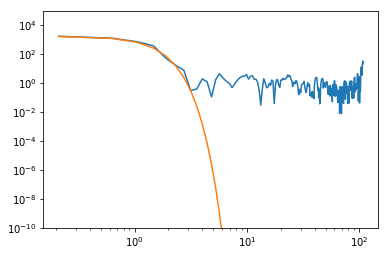

In [6]:
try:
    for r in pv['res']:
        for rl in r[2]:
            plt.plot(r[0],np.abs(rl.visibility_circular[0]),alpha=0.3,color="C1")
except:
    plt.plot(pv['ppf'].ugrid0_vis,np.abs(pv['ppf'].visibility_circular[0]))
plt.plot(pv['res'][0][0], pv_model.visibility_circular)
plt.ylim((1e-10,1e5))
plt.xscale('log')
plt.yscale('log')

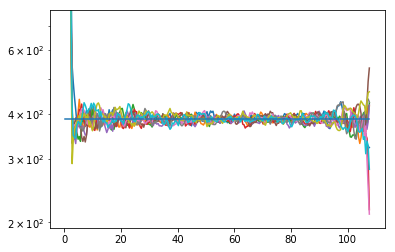

In [5]:
for r in pv['res']:
    plt.plot(r[0][4:],r[1][4:])
model = PointSourceCircularGaussian(pv['sc'],pv['beam'],pv['res'][0][0]).poisson_covariance[0,0]  #gaussian_beam_covar(pv['res'][0][0],pv['sc'], pv['beam'])
plt.plot(pv['res'][0][0],model)
#plt.xscale('log')
plt.yscale('log')
plt.ylim((model[0]/2,model[0]*2))
plt.show()

### Covariances

#### Setup Mocks

In [7]:
pc = {}
pc['sc'],pc['beam'],pc['ppf'], pc['res'] = get_cov_poisson(np.linspace(1,1.1,2))

#### Define Model

In [8]:
pc_model = PointSourceCircularGaussian(pc['sc'],pc['beam'],pc['res'][0][0])

#### Compare

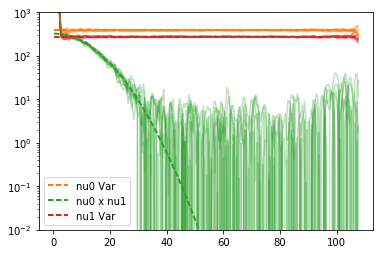

In [9]:
for r in pc['res']:
    plt.plot(r[0][4:],r[1][0,0,4:],color="C1",alpha=0.3)
    plt.plot(r[0][4:],r[1][0,1,4:],color="C2",alpha=0.3)
    plt.plot(r[0][4:],r[1][1,1,4:],color="C3",alpha=0.3)
    
model = pc_model.poisson_covariance# gaussian_beam_covar(pc['res'][0][0],pc['sc'], pc['beam'])
plt.plot(pc['res'][0][0],model[0,0],color="C1",lw=2,ls="--",label='nu0 Var')
plt.plot(pc['res'][0][0],model[0,1],color="C2",lw=2,ls="--",label='nu0 x nu1')
plt.plot(pc['res'][0][0],model[1,1],color="C3",lw=2,ls="--",label='nu1 Var')

#plt.xscale('log')
plt.yscale('log')
plt.ylim((1e-2,1e3))
plt.legend()
#plt.ylim((model[0]/2,model[0]*2))
plt.show()

## Clustering Ya'll

### Variances

#### Setup

In [3]:
def get_cov_clustered(nu, pk, ncells=256, Smin=0.1,Smax=1.0,alpha=4100.,beta=1.59,nu0=150.):
    sc = PowerLawSourceCounts(nu=nu,Smax0=Smax,Smin0=Smin,alpha=alpha,beta = beta)
    beam = CircularGaussian(nu0,nu=nu)

    ppf = ClusteredForegrounds(pk,sc,beam,ncells=ncells,seed=1234)
    
    res = [0]*10
    for i in range(10):
        res[i] = visibility_covariance(foreground_model=ClusteredForegrounds,point_source_power_spec=pk,
                                       source_counts=sc,beam_model = beam,ncells=ncells,ret_realisations=False)
        
    return sc,beam,ppf, res

#### Zero Power Spectrum

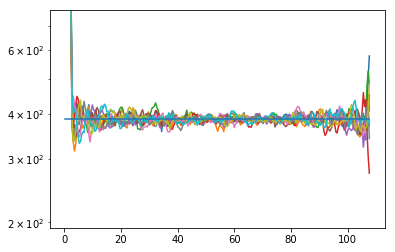

In [11]:
cv0 = {}
cv0['sc'],cv0['beam'],cv0['ppf'], cv0['res'] = get_cov_clustered(1,lambda u : np.zeros_like(u))

for r in cv0['res']:
    plt.plot(r[0][4:],r[1][4:])

model = PointSourceCircularGaussian(cv0['sc'],cv0['beam'],cv0['res'][0][0]).poisson_covariance[0,0]
#model = gaussianB_gaussianP_cluster_cov(cv['sc'],cv['beam'],cv['res'][0][0])
plt.plot(cv0['res'][0][0],model)
plt.yscale('log')
plt.ylim((model[0]/2,model[0]*2))
plt.show()

#### Truncated Power-Law

In [39]:
def truncated_powerlaw(w,w0,xi):
    return (w/w0)**-xi
    
cv_pl = {}
cv_pl['sc'],cv_pl['beam'],cv_pl['ppf'], cv_pl['res'] = get_cov_clustered(1,lambda u : truncated_powerlaw(u,1,2.))

/home/steven/anaconda2/lib/python2.7/site-packages/spore-0.0.1-py2.7.egg/spore/mock/mock_ps_foregrounds.py:178: ComplexWarning: Casting complex values to real discards the imaginary part


In [28]:
def eq_C16(u,source_counts,beam,Ik,kmax=10,kmin=0, tol=1e-3,verbose=False):
    ## Note, T_s not included here.
    
    sd, sdd = np.meshgrid(beam.sigma,beam.sigma,sparse=True,copy=False)
    s0 = beam.sigma * beam.nu[0]
    nud,nudd = np.meshgrid(beam.nu,beam.nu,sparse=True,copy=False)
    
    
    prefac =  np.exp(-4*np.pi**2*s0**2*u**2) * 2*np.pi*sd**2*sdd**2
    if verbose: print "Prefac: ", prefac
    res = 0
    for k in range(kmin,kmax+1):
    
        kbits = (-1)**k * Ik(k) * sdd**(2*k) /factorial(k)**2
        
        if verbose: print "k: ", k, "kbits: ", kbits
        
        qsum = 0
        for q in range(k+1):
            qbits = (-1)**q * binom(k,q)*2.**(1-k-3*q)*factorial(2*q)
        
            if verbose: print "k: ", k, "q: ", q, "qbits: ", qbits
            
            psum = 0
            for p in range(2*q+1):
                pbits = (nudd/nud)**p
            
                mnsum = 0
                for m in range(p/2+1):
                    for n in range((2*q-p)/2+1):
                        mnbits = (-1)**(n+m) * hermite(p-2*m)(2*np.pi*s0*u)*hermite(2*q-p-2*n)(2*np.pi*s0*u)/(factorial(m)*factorial(n)*factorial(p-2*m)*factorial(2*q-p-2*n))
                        mnsum += mnbits
                        #if verbose: print "k: ", k, "q: ", q, "p: ", p, "m: ", "n: ", psum: ", psum, 'pterm: ', pbits*qbits*kbits
            
                psum += pbits*mnsum
            
                if verbose: print "k: ", k, "q: ", q, "p: ", p, "psum: ", psum, 'pterm: ', pbits*qbits*kbits
            
            jsum = 0
            for j in range(k-q+1):
                jbits = binom(2*(k-q),2*j)*(nudd/nud)**(2*j) * gamma(j+0.5)*gamma(k-q-j+0.5)
                jsum += jbits

                if verbose: print "k: ", k, "q: ", q, "j: ", p, "jsum: ", jsum, "jterm: ", jsum*qbits*kbits
                    
            qsum += qbits * psum * jsum
        
            if verbose: print "k: ", k, "q: ", q, "qsum: ", qsum, "qterm: ", qsum*kbits
            
        ksum = prefac*kbits*qsum
        
        
        if tol and k>kmin:
            #print ksum,ksum+res,np.abs(ksum/(ksum+res)),tol,np.all(np.abs(ksum/(ksum+res))<tol)
            if np.all(np.abs(ksum/(ksum+res))<tol):
                return ksum+res, (k,np.abs(ksum/(ksum+res)))
            
        res += ksum

        if verbose: print "k: ", k, "ksum: ", res/prefac

    
    print "WARNING: Sum never converged"
    return res, (k,np.abs(ksum/(ksum+res)))

def Ik_pl(k,xi,w0,wmin,wmax):
    if k==(xi-2)/2.:
        return w0**xi * np.log(wmax/wmin)
    else:
        oddbit = 2 + 2*k - xi
        return (wmax**oddbit - wmin**oddbit)*w0**xi / oddbit
    
def gaussian_cluster_cov_expansion(u,source_counts,beam,Ik):
    cluster_prefac = np.outer(source_counts.total_flux_density,source_counts.total_flux_density)
    return cluster_prefac * eq_C16(u,source_counts,beam,Ik,kmax=10,kmin=0, tol=1e-3,verbose=False)[0] + PointSourceCircularGaussian(source_counts,beam,u).poisson_covariance

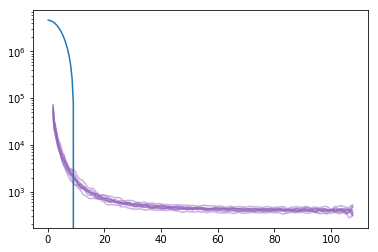

In [15]:
for r in cv_pl['res']:
    plt.plot(r[0][4:],r[1][4:],color="C4",alpha=0.5)
    
#modelc = gaussian_cluster_cov_expansion(cv_pl['res'][0][0],cv_pl['sc'],cv_pl['beam'],lambda k : Ik_pl(k,2.,1., 2*np.pi/cv_pl['ppf'].sky_size.max(), 2*np.pi*cv_pl['ppf'].sky_size.max()/cv_pl['ppf'].ncells))
#modelp = PointSourceCircularGaussian(cv0['sc'],cv0['beam'],cv0['res'][0][0]).poisson_covariance[0,0]
modelkspace = kspace_var_gaussian_pl(cv_pl['res'][0][0],cv_pl['sc'],cv_pl['beam'],-2.,1,2*np.pi/cv_pl['ppf'].sky_size.max(), 2*np.pi*cv_pl['ppf'].sky_size.max()/cv_pl['ppf'].ncells)

#plt.plot(cv_pl['res'][0][0],modelp)
#plt.plot(cv_pl['res'][0][0],modelc[0,0])
plt.plot(cv_pl['res'][0][0],modelkspace)

plt.yscale('log')
plt.show()

### Testing the k-Space formalism

In [4]:
from scipy.signal import convolve2d as _cv2d
from powerbox import LogNormalPowerBox
from powerbox import angular_average

def convolve2d(X,Y,dx,dy=None,*args,**kwargs):
    if dy is None:
        dy = dx
    return dx*dy * _cv2d(X,Y,*args,**kwargs)

def circavg(X,cf):
    return angular_average(X,cf._ugrid0,len(cf.ugrid))

#### Check expected sky-realisation

We have 

$$ S = \bar{S}_0 \left[B \mathcal{F}^{-1}_{1,1} \left[\sqrt{P} \mathcal{N} e^{iX}\right] + B\right]. $$

We can check the expectation of the sky signal, which should be equivalently the beam:

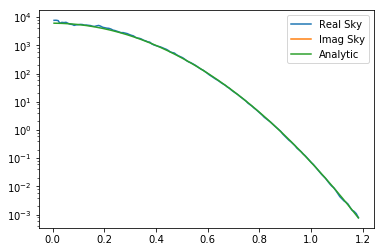

In [67]:
## Setup temporary clustering foregrounds model
nreal=50
sky =[0]*nreal
for i in range(nreal):
    cf = ClusteredForegroundsOnly(point_source_power_spec=lambda u : u**-1.5,
                                  use_lognormal=False,
                                  source_counts=PowerLawSourceCounts(nu=1.,Smax0=1.,Smin0=0.1,alpha=4100.,beta=1.59), 
                                  beam_model=CircularGaussian(150.,nu=1.),
                                  sky_size=4, ncells=256)
    L,M = np.meshgrid(cf.lgrid[0],cf.lgrid[0])
    lgrid = np.sqrt(L**2+M**2)
    
    sky[i],bins = angular_average(np.real(cf.visible_sky()[0]),lgrid,150)
        
plt.plot(bins,np.mean(np.real(sky),axis=0),label="Real Sky")
plt.plot(bins,np.mean(np.imag(sky),axis=0),label="Imag Sky")

plt.plot(bins,cf.source_counts.total_flux_density*angular_average(cf.beam_attenuation()[0],lgrid,150)[0],label="Analytic")
plt.legend()
plt.yscale('log')

#### Check Fourier transform of beam

The gaussian beam is

$$ B(r) = e^{-r^2/s\sigma^2}.$$

The fourier-transform of the beam, using the Fourier convention used in visibilities is

$$ \mathcal{F}_{0,2\pi}(B) \equiv \hat{B} = 2\pi \sigma^2 e^{-2\pi^2\sigma^2 u^2}, $$

where the hat will refer *only* to the $(0,2\pi)$ fourier convention in this document.

I'm not quit sure why, but the FFT gives alternating negative and positive values for the fourier transform, but the magnitude is correct...

(1e-17, 1000.0)

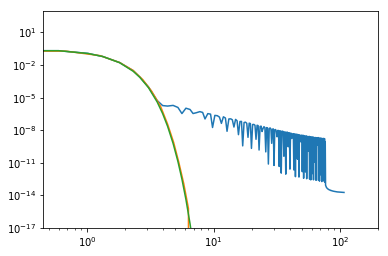

In [12]:
## Setup temporary clustering foregrounds model
cf = ClusteredForegroundsOnly(point_source_power_spec=lambda u : u**-1.5,
                              source_counts=PowerLawSourceCounts(nu=1.,Smax0=1.,Smin0=0.1), 
                              beam_model=CircularGaussian(150.,nu=1.),
                              sky_size=4, ncells=256)

model = PointSourceCircularGaussian(source_counts=cf.source_counts, beam_model=cf.beam_model, u = cf.ugrid)

# Get 2D FT(B) and average.
ft_b, bins = angular_average(model.beam_model.fourier_beam(_magnitude_grid(model.u,2)),_magnitude_grid(model.u,2),300)

# Numerical beam transform
plt.plot(cf.ugrid, circavg(np.abs(fftshift(fft2(cf.beam_attenuation()[0])))*cf.cell_area,cf)[0])
plt.plot(bins,ft_b)
plt.plot(model.u, model.beam_model.fourier_beam_1D(model.u)[0])
#plt.plot(model.u, model.mean_visibility_circular)

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-17,1e3)

#### Check Mean Visibility

At $\nu_0$, the visibility is

\begin{equation}
	V = \bar{S}_0 \mathcal{F}_{0,2\pi} \left[B \mathcal{F}^{-1}_{1,1}\left[\sqrt{P} \mathcal{N} e^{iX}\right]+B \right].
\end{equation}

Here,the subscripts on the fourier transforms denote their conventions. We want to find the expectation of the magnitude of the visibility (since this is more closely related to the variance). To render things messily, this looks like:


\begin{equation}
	V = \bar{S}_0  \left(\hat{B} \otimes \mathcal{F}_{0,2\pi}\left[\mathcal{F}^{-1}_{1,1}\left[\sqrt{P} \mathcal{N} e^{iX}\right]\right]+\hat{B} \right).
\end{equation}

There are two things to concern ourselves with here: the definition of a (symmetric) convolution, and the result of a mixed forward-backward transform. We do each in turn.

##### Check Symmetric Convolution Identity

In this case, the fourier transform that is invoking the convolution is a standard $(0,2\pi)$ transform. According to Wikipedia, this results in a standard convolution:

$$ \mathcal{F}_{0,2\pi}[fg] = \hat{f} \otimes \hat{g} \equiv \int_{-\infty}^{+\infty} f(\tau)g(t-\tau) d\tau, $$

and we'll test this. 

We also then want to test the following identity, which applies for symmetric convolutions:

$$ \hat{f} \otimes \hat{g} = 2\pi \int r J_0(2\pi u r) f(r) g(r) dr. $$

To test this simply, we take $f=g=e^{-\pi x^2}$ in 2D.

/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in power


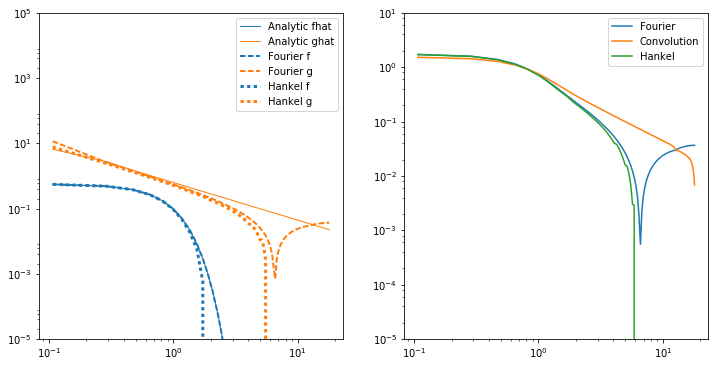

In [144]:
Ngrid = 256
L = 10.0

A, alpha = 1,0.85
a_squared = 1./(2*np.pi*0.3**2)
a,b = 0,2*np.pi

# Real-space grid
x = np.arange(-L/2,L/2,L/Ngrid)[:Ngrid]
X,Y = np.meshgrid(x,x)
xgrid = np.sqrt(X**2+Y**2)

# Real-space functions
f_fc = lambda x : np.exp(-np.pi*a_squared*x**2) 
g_fc = lambda x : np.where(x!=0,A*x**-alpha, 0)
f = f_fc(xgrid)
g = g_fc(xgrid)

# Do 2D FT
fft_prod_, u, ugrid = fft(f*g,L=L,a=a,b=b, ret_cubegrid=True)
fft_f_ = fft(f,L=L,a=a,b=b, ret_cubegrid=True)[0]
fft_g_ = fft(g,L=L,a=a,b=b, ret_cubegrid=True)[0]

fft_prod, ubins = angular_average(np.abs(fft_prod_),ugrid,100)
fft_f = angular_average(np.abs(fft_f_),ugrid,100)[0]
fft_g = angular_average(np.abs(fft_g_),ugrid,100)[0]

du = u[0][1] - u[0][0]
# Fourier-space grid
#u = fftfreq(Ngrid,d=L/Ngrid,b=b)
#U,V = np.meshgrid(u,u)
#ugrid = np.sqrt(U**2+V**2)

# Fourier-space functions
fhat_fc = lambda u : (1./a_squared) * np.exp(-np.pi * u**2/a_squared)
ghat_fc = lambda u : 2*np.pi* 2**(1-alpha) * gamma(1-alpha/2)*(b*u)**(alpha-2)/gamma(alpha/2)
fhat = fhat_fc(ugrid)
ghat = ghat_fc(ugrid)
ghat[ugrid==0] = 0

# Analytic FT
anl_f = angular_average(fhat,ugrid,100)[0]
anl_g = angular_average(ghat,ugrid,100)[0]

# Do 2D convolution
conv_res = convolve2d(fhat,ghat,dx=du,mode='same',boundary='fill')
conv_res = angular_average(conv_res,ugrid,100)[0]


# Do Hankel convolution
ht = SymmetricFourierTransform(ndim=2,N=10000,h=0.0001,a=a,b=b)
hankel_prod = ht.transform(f=lambda x : np.where(x>=L/Ngrid/np.sqrt(2),g_fc(x) * f_fc(x),0), k = ubins)[0]
hankel_f = ht.transform(f=lambda x : np.where(x>=L/Ngrid/np.sqrt(2),f_fc(x),0), k = ubins)[0]
hankel_g = ht.transform(f=lambda x : np.where(x>=L/Ngrid/np.sqrt(2),g_fc(x),0), k = ubins)[0]

fig,ax = plt.subplots(1,2,figsize=(12,6),subplot_kw={'xscale':'log','yscale':'log'})

ax[0].plot(ubins,anl_f,label="Analytic fhat",color="C0",ls='-',lw=1)
ax[0].plot(ubins,anl_g,label="Analytic ghat",color="C1",ls='-',lw=1)
ax[0].plot(ubins,fft_f,label="Fourier f",color="C0",ls='--',lw=2)
ax[0].plot(ubins,fft_g,label="Fourier g",color="C1",ls='--',lw=2)
ax[0].plot(ubins,hankel_f,label="Hankel f",color="C0",ls=':',lw=3)
ax[0].plot(ubins,hankel_g,label="Hankel g",color="C1",ls=':',lw=3)
ax[0].set_ylim(1e-5,1e5)
ax[0].legend()


ax[1].plot(ubins,fft_prod,label="Fourier")
ax[1].plot(ubins,conv_res,label="Convolution")
ax[1].plot(ubins,hankel_prod,label="Hankel")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-5,1e1)
ax[1].legend()


/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


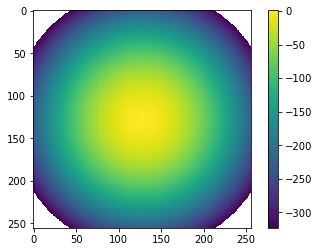

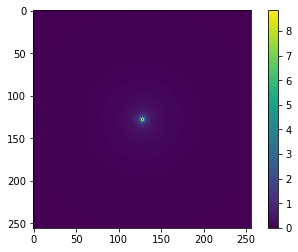

In [139]:
plt.imshow(np.log10(fhat*ghat))
plt.colorbar()
plt.show()

plt.imshow(ghat)
plt.colorbar()
plt.show()


##### Mixed-Convention Round-trip

Here we test a mixed round-trip. That is, given an $n$-dimensional forward transform with parameters $a,b$ and an inverse transform with parameters $a',b'$, doing a forward-then-backward transform should yield:

$$ \left( \frac{b'}{b(2\pi)^{a'-a}}\right)^{n/2} f\left(\frac{b'r}{b}\right), $$

and doing it the other way should yield:

$$ \left( \frac{b}{b'(2\pi)^{a'-a}}\right)^{n/2} F\left(\frac{bk}{b'}\right). $$

In our case, we are doing the 2D backward-then-forward transform, where the forward has $(0,2\pi)$ and backward has parameters $(1,1)$. This should result in $ F(2\pi k) $.

Just for fun, we'll try this on the actual power array.

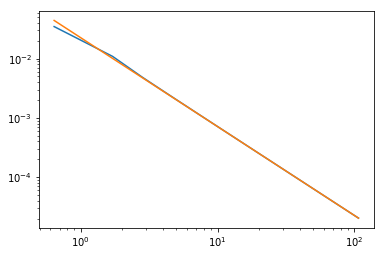

In [52]:
## Setup temporary clustering foregrounds model
cf = ClusteredForegroundsOnly(point_source_power_spec=lambda u : u**-1.5,
                              source_counts=PowerLawSourceCounts(nu=1.,Smax0=1.,Smin0=0.1), 
                              beam_model=CircularGaussian(150.,nu=1.),
                              sky_size=4, ncells=256)

realspace, xfreq = ifft(cf.powerbox.power_array,L=cf.sky_size[0],a=1,b=1)
res, freq, grid = fft(realspace,L=cf.sky_size[0],a=0,b=2*np.pi,ret_cubegrid=True)
res,bins = angular_average(res,grid,100)

plt.plot(bins,res)
plt.plot(bins, cf.powerbox.pk(2*np.pi*bins))
plt.xscale('log')
plt.yscale('log')

##### Actually check mean visibility

Remember that we have

\begin{equation}
	V = \bar{S}_0  \left(\hat{B} \otimes \mathcal{F}_{0,2\pi}\left[\mathcal{F}^{-1}_{1,1}\left[\sqrt{P} \mathcal{N} e^{iX}\right]\right]+\hat{B} \right).
\end{equation}

We can now evaluate the fourier back/forward part:

\begin{equation}
	V = \bar{S}_0  \left(\hat{B} \otimes \left[\sqrt{P(2\pi u)} \mathcal{N} e^{iX}\right]+\hat{B} \right).
\end{equation}

Thus the expectation of $V$ should be $\hat{B}$. 

In [20]:
nreal = 200
vis = [0]*nreal
for i in range(nreal):
    cf = ClusteredForegroundsOnly(point_source_power_spec=lambda u : 1,#u**-1.5,
                                  source_counts=PowerLawSourceCounts(nu=1.,Smax0=1.,Smin0=0.1,alpha=4100.,beta=1.59), 
                                  beam_model=CircularGaussian(150.,nu=1.),
                                  sky_size=4, ncells=256)

    model = PointSourceCircularGaussian(source_counts=cf.source_counts, beam_model=cf.beam_model, u = cf.ugrid)
    vis[i] = cf.visibility_1d[0] #vis_rl + 1j*vis_im

(1.0, 10000.0)

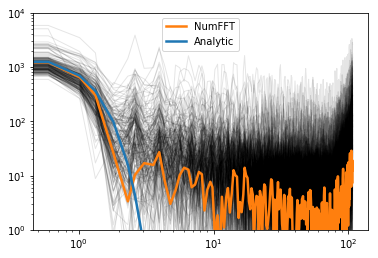

In [21]:
for i in range(nreal):
    plt.plot(cf.ugrid,np.abs(vis[i]),color='k',lw=1,alpha=0.1)

plt.plot(cf.ugrid,np.abs(np.mean(vis,axis=0)),color="C1",lw=2.5,label="NumFFT")
plt.plot(model.u, model.mean_visibility_circular[0],color="C0",lw=2.5,label="Analytic")

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e0,1e4)

#### Full Variance.

Recall that we have

\begin{equation}
	V = \bar{S}_0  \left(\hat{B} \otimes \left[\sqrt{P(2\pi u)} \mathcal{N} e^{iX}\right]+\hat{B} \right).
\end{equation}

Now the variance of $V$ is the variance of a sum (the convolution), in which each term is uncorrelated. So the variance must be

\begin{equation}
	Var(V) = \bar{S}^2_0  \hat{B}^2 \otimes \left[P(2\pi u) Var\left(\mathcal{N} e^{iX}\right)\right].
\end{equation}

But the variance of the complex normal is 1, so we have

\begin{equation}
	Var(V) = \bar{S}^2_0  \hat{B}^2 \otimes P(2\pi u)
\end{equation}

In [5]:
cf = ClusteredForegroundsOnly(point_source_power_spec=lambda u :  (u/0.001)**-1.,
                              use_lognormal=False,
                              source_counts=PowerLawSourceCounts(nu=1.,Smax0=1.,Smin0=0.1,alpha=4100.,beta=1.59), 
                              beam_model=CircularGaussian(150.,nu=1.),
                              sky_size=4, ncells=512,seed=1234)
model1 = PointSourceCircularGaussian(source_counts=cf.source_counts,
                                    beam_model=cf.beam_model,
                                    u =cf.ugrid_raw0,
                                    clustering_params={"func":cf.point_source_power_spec})

model2 = CircularGaussianPowerLaw(source_counts=cf.source_counts,
                                  beam_model=cf.beam_model,
                                  u =cf.ugrid_raw0,
                                  clustering_params={"u0":0.001,"kappa":1.})


ubins, vis_var = visibility_covariance(foreground_model=cf.__class__,
                                       niter=50, seed=None,#cf.seed,
                                       point_source_power_spec=cf.point_source_power_spec,
                                       use_lognormal=False,
                                       source_counts=cf.source_counts, 
                                       beam_model=cf.beam_model,
                                       sky_size=4, ncells=cf.ncells)

/home/steven/anaconda2/lib/python2.7/site-packages/spore-0.0.1-py2.7.egg/spore/mock/mock_ps_foregrounds.py:186: ComplexWarning: Casting complex values to real discards the imaginary part
/home/steven/anaconda2/lib/python2.7/site-packages/spore-0.0.1-py2.7.egg/spore/mock/mock_ps_foregrounds.py:187: ComplexWarning: Casting complex values to real discards the imaginary part


In [165]:
# Try convolution via fourier transforms
ft_res = np.abs(fft(beamterm * power_term, L=cf.sky_size[0],ret_cubegrid=True,a=0,b=2*np.pi)[0])

ft_res = angular_average(ft_res,cf._ugrid0,cf._ugrid_edges)[0]
ft_res *= cf.source_counts.total_flux_density**2

In [6]:
ht = SymmetricFourierTransform(ndim=2,N=1000,h=0.0002,a=0,b=2*np.pi)
integrand = lambda r : np.where(r<=0.8,0.001*r**-1.*beam_term(r)/(2*np.pi),0)

hankel_res = ht.transform(integrand,k=ubins,ret_err=False) * cf.source_counts.total_flux_density**2

/home/steven/anaconda2/lib/python2.7/site-packages/hankel/hankel.py:174: RuntimeWarning: divide by zero encountered in divide
  fres = self._f(f, np.divide.outer(self.x, k).T)*self.x**self._x_power


NameError: global name 'beam_term' is not defined

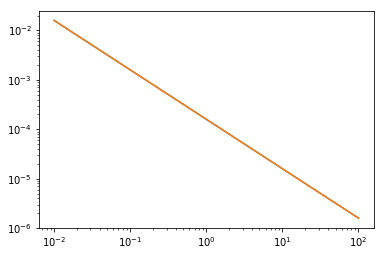

In [202]:
r = np.logspace(-2,2,100)

ht1 = SymmetricFourierTransform(ndim=2,N=1000,h=0.003,a=0,b=2*np.pi)
gres = ht1.transform(lambda u : cf.point_source_power_spec(2*np.pi*u), k = r, inverse=True,ret_err=False)

xir = spline(np.log(r),np.log(gres))
integrand2 = lambda r : np.exp(xir(np.log(r)))*beam_term(r)

hankel_res2 = ht.transform(integrand2,k=ubins,ret_err=False) * cf.source_counts.total_flux_density**2
plt.plot(r,0.001*r**-1./(2*np.pi))
plt.plot(r,gres)
plt.xscale('log')
plt.yscale('log')

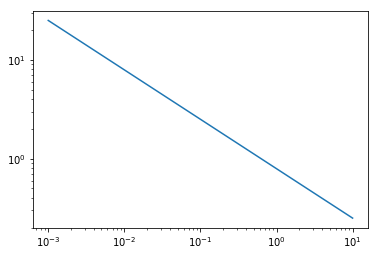

In [25]:
plt.plot(r,xir(r))
plt.xscale('log')
plt.yscale('log')

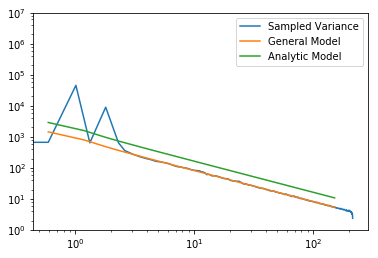

In [7]:
plt.plot(ubins,vis_var,label="Sampled Variance")
plt.plot(model1.u,model1.clustered_covariance()[:,0,0],label="General Model")
plt.plot(model2.u,model2.clustered_covariance()[:,0,0],label="Analytic Model")

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e0,1e7)
plt.legend()

#### Full Covariance

Recall that we have

\begin{equation}
	V = \bar{S}_0  \left(\hat{B} \otimes \left[\sqrt{P(2\pi u)} \mathcal{N} e^{iX}\right]+\hat{B} \right).
\end{equation}

Our first task is to generalise the visibility to the case of arbitrary frequency. We let the beam be a function of frequency and note that 

$$ \int B(\vec{l}) e^{-2\pi i \nu \vec{u}\cdot \vec{l}} d\vec{l} = \frac{1}{\nu}\int B(\vec{y}/\nu) e^{-2\pi i \vec{u}\cdot \vec{y}} d\vec{y} = \frac{1}{\nu} \hat{B(l/\nu)}. $$

Furthermore, the back/forward transform is modified by an extra factor of $\nu$ in its argument. So finally we have

\begin{equation}
V_\nu =  \frac{\bar{S}_0}{\nu^{1+\gamma}} \left(\mathcal{F}(B_\nu(r/\nu)) \otimes \left[\sqrt{P}(2\pi\nu u)\mathcal{N}e^{iX}\right] + \mathcal{F} B_\nu(r/\nu) \right).
\end{equation} 

Of course, now we do the same thing as for the variance, but noting that the frequencies are different:

\begin{equation}
		{\rm Cov}(V(\nu',\nu''; u) = \frac{\bar{S}_0^2}{(\nu'\nu'')^{1+\gamma}} \int \widehat{B_{\nu'}(r/\nu')}(\vec{u}-\vec{u}_1)\widehat{B_{\nu''}(r/\nu'')}(\vec{u}-\vec{u}_1)\sqrt{P(2\pi\nu'u_1)}\sqrt{P(2\pi\nu'' u_1)} d^2\vec{u}_1.
\end{equation}

In [7]:
u0 = 0.1
kappa = 1.45

cf_cov = ClusteredForegrounds(point_source_power_spec=lambda u : (u/u0)**-kappa,
                                  use_lognormal=True,
                                  source_counts=PowerLawSourceCounts(nu=[1.,1.2],Smax0=1.,Smin0=0.1,alpha=4100.,beta=1.59), 
                                  beam_model=CircularGaussian(150.,nu=[1.,1.2]),
                                  sky_size=4, ncells=256,seed=1234)

cof_cov = ClusteredForegroundsOnly(point_source_power_spec=lambda u : (u/u0)**-kappa,
                                  use_lognormal=True,
                                  source_counts=PowerLawSourceCounts(nu=[1.,1.2],Smax0=1.,Smin0=0.1,alpha=4100.,beta=1.59), 
                                  beam_model=CircularGaussian(150.,nu=[1.,1.2]),
                                  sky_size=4, ncells=256,seed=1234)

model1_cov = PointSourceCircularGaussian(source_counts=cf_cov.source_counts,
                                    beam_model=cf_cov.beam_model,
                                    u =np.logspace(-1,2,50),
                                    clustering_params={"func":cf_cov.point_source_power_spec})

model2_cov = CircularGaussianPowerLaw(source_counts=cf_cov.source_counts,
                                  beam_model=cf_cov.beam_model,
                                  u =np.logspace(-1,2,50),
                                  clustering_params={"u0":u0,"kappa":kappa})

ubins, vis_covar = visibility_covariance(foreground_model=cf_cov.__class__,
                                       niter=50, seed=cf_cov.seed,
                                       point_source_power_spec=cf_cov.point_source_power_spec,
                                       use_lognormal=True,
                                       source_counts=cf_cov.source_counts, 
                                       beam_model=cf_cov.beam_model,
                                       sky_size=4, ncells=cf_cov.ncells)

ubins, vis_covar_only = visibility_covariance(foreground_model=cof_cov.__class__,
                                       niter=50, seed=cf_cov.seed,
                                       point_source_power_spec=cf_cov.point_source_power_spec,
                                       use_lognormal=True,
                                       source_counts=cf_cov.source_counts, 
                                       beam_model=cf_cov.beam_model,
                                       sky_size=4, ncells=cf_cov.ncells)


In [20]:
# # Get it analytically
# u = cf_cov._ugrid0.reshape((cf_cov.ncells,cf_cov.ncells))
# du = cf_cov.ugrid_raw0[1] - cf_cov.ugrid_raw0[0]

# # Analytic beam transform
# ft_b = 2*np.pi*cf_cov.beam_model.sigma[0]**2 * np.exp(-2*np.pi**2 * cf_cov.beam_model.sigma[0]**2 * u**2)

# p1 = np.zeros_like(u)
# p2 = np.zeros_like(u)

# p1[u!=0] = np.sqrt(cf_cov.point_source_power_spec(2*np.pi*u[u!=0]))#*cf_cov.nu[0]
# p2[u!=0] = np.sqrt(cf_cov.point_source_power_spec(2*np.pi*u[u!=0]))#*cf_cov.nu[1]


# # Do 2D convolution
# conv_res_00 = convolve2d(ft_b**2,p1*p1,dx=du,mode='same',boundary='fill')
# conv_res_00, conv_bins = angular_average(conv_res_00,u,300)
# conv_res_00 *= cf_cov.source_counts.total_flux_density[0]*cf_cov.source_counts.total_flux_density[0]/ (cf_cov.nu[0]*cf_cov.nu[0])**2

# conv_res_01 = convolve2d(ft_b**2,p1*p2,dx=du,mode='same',boundary='fill')
# conv_res_01, conv_bins = angular_average(conv_res_01,u,300)
# conv_res_01 *= cf_cov.source_counts.total_flux_density[0]*cf_cov.source_counts.total_flux_density[1]/ (cf_cov.nu[0]*cf_cov.nu[1])**2

# conv_res_11 = convolve2d(ft_b**2,p2*p2,dx=du,mode='same',boundary='fill')
# conv_res_11, conv_bins = angular_average(conv_res_11,u,300)
# conv_res_11 *= cf_cov.source_counts.total_flux_density[1]*cf_cov.source_counts.total_flux_density[1]/ (cf_cov.nu[1]*cf_cov.nu[1])**2

KeyboardInterrupt: 

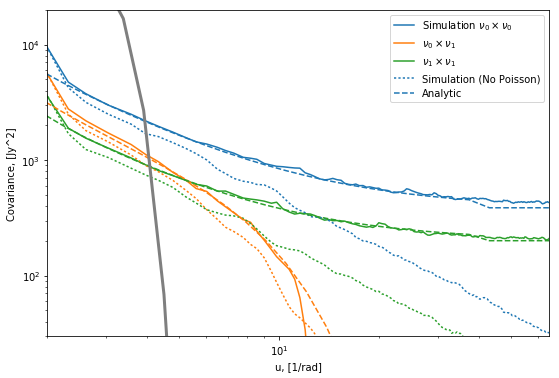

In [26]:
plt.figure(figsize=(9,6))

plt.plot(ubins,vis_covar[0,0],label=r"Simulation $\nu_0 \times \nu_0$",color="C0")
plt.plot(ubins,vis_covar[0,1],label=r"$\nu_0 \times \nu_1$",color="C1")
plt.plot(ubins,vis_covar[1,1],label=r"$\nu_1 \times \nu_1$",color="C2")

plt.plot(ubins,vis_covar_only[0,0],label=r"Simulation (No Poisson)",ls=':',color="C0")
plt.plot(ubins,vis_covar_only[0,1],color="C1",ls=':')
plt.plot(ubins,vis_covar_only[1,1],color="C2",ls=':')
#plt.plot(ubins,vis_var,color="C5")

#anl_cov1 =model1_cov.clustered_only_covariance
anl_cov2 =model2_cov.clustered_only_covariance


# plt.plot(model1_cov.u,anl_cov1[:,0,0], color="C0",ls='--', label="Hankel")
# plt.plot(model1_cov.u,anl_cov1[:,0,1], color="C1",ls='--')
# plt.plot(model1_cov.u,anl_cov1[:,1,1], color="C2",ls='--')


#plt.plot(model2_cov.u,anl_cov2[:,0,0],color="C0",ls=':', label="Hankel")
#plt.plot(model2_cov.u,anl_cov2[:,0,1],color="C1",ls=':')#*nu1**(kappa/2)
plt.plot(model2_cov.u,model2_cov.total_covariance[:,0,0],color="C0",ls='--', label="Analytic")
plt.plot(model2_cov.u,model2_cov.total_covariance[:,0,1],color="C1",ls="--")
plt.plot(model2_cov.u,model2_cov.total_covariance[:,1,1],color="C2",ls='--')
plt.plot(model2_cov.u, res, color="C7",lw=3)
#plt.plot(model2_cov.u,res,color="C5",ls='--')
#plt.plot(model2_cov.u,anl_cov2[:,0,1],color="C1",ls=':')#*(nu1*nu1)**(kappa/2) 


#plt.plot(model1_cov.u,model2_cov.poisson_covariance[:,0,0],color="C0",ls='--')
#plt.plot(model1_cov.u,model2_cov.poisson_covariance[:,0,1],color="C1",ls='--')#*nu1**(kappa/2)
#plt.plot(model1_cov.u,model2_cov.poisson_covariance[:,0,1] ,color="C1",ls=':', label="Clustered/Uniform Components")#*(nu1*nu1)**(kappa/2)

# plt.plot(conv_bins,conv_res_00, color="C0",ls='-.')
# plt.plot(conv_bins,conv_res_01 , color="C1",ls='-.')#* nu1**(kappa/2)
# plt.plot(conv_bins,conv_res_11 , color="C2",ls='-.')#* nu1**kappa

#plt.plot(conv_bins,conv_res,color="C4")

plt.xlabel("u, [1/rad]")
plt.ylabel("Covariance, [Jy^2]")

plt.xscale('log')
plt.yscale('log')
plt.ylim(30,2e4)
plt.xlim(2,65)
plt.legend()

In [24]:
s = model2_cov.beam_model.sigma[0]
nu1 = model2_cov.nu[0]
nu2= model2_cov.nu[1]
u = model2_cov.u

frontbit = (2*np.pi)**(2-kappa) * model2_cov.source_counts.total_flux_density[0]**2 * nu1**(-kappa) * s**4 / (nu1*nu2)**(2+model2_cov.source_counts.spectral_index)
otherfront = 2*np.pi * np.exp(-4*np.pi**2 * s**2*u**2)

k = np.arange(20)
y = np.atleast_2d(4*np.pi**2*s**2*u*(1+nu2/nu1))

sumbit = y.T**(2*k) * (2*np.pi**2*s**2*(1+nu2**2/nu1**2))**(-(2*k+2-kappa)/2) * gamma((2*k+2-kappa)/2)/(4**k * factorial(k)**2 * 2)

res = frontbit*otherfront*np.sum(sumbit,axis=1)

In [25]:
res

array([  9.87475743e+005,   9.83428473e+005,   9.78093298e+005,
         9.71073339e+005,   9.61859091e+005,   9.49803707e+005,
         9.34098495e+005,   9.13753931e+005,   8.87595964e+005,
         8.54293993e+005,   8.12445438e+005,   7.60750242e+005,
         6.98310881e+005,   6.25076560e+005,   5.42393537e+005,
         4.53507223e+005,   3.63698947e+005,   2.79636541e+005,
         2.07706275e+005,   1.51780601e+005,   1.11764628e+005,
         8.42488421e+004,   6.48909552e+004,   5.01661654e+004,
         3.57984155e+004,   1.67976906e+004,   2.69438816e+003,
         6.86058154e+001,   1.21251518e-001,   5.56842687e-006,
         1.90656431e-012,   9.54026033e-022,   8.15112101e-035,
         6.95456646e-053,   1.38064683e-077,   4.37974663e-111,
         3.01556797e-156,   7.13776597e-217,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+

## Smash out a "realistic" covariance

In [7]:
covar.keys()

[]

In [4]:
REDO = False

ncells = 350
Smax = 1.
nu0 = 150.

nu = np.linspace(1,180./150.,71)
beam = CircularGaussian(nu0,nu=nu)

covar = {}
pcov = {}
for Smin,u0,xi in [[0.1,1.,1.5],
                   [0.01,1,1.5],
                   [0.1,10,1.5],
                   [0.1,0.1,1.5],
                   [0.1,1.,2.],
                   [0.1,1,0.5],
                   [0.01,1,0.5],
                   [0.01,1,2.]]:
    tag = 'Smin_%s_u0_%s_xi_%s'%(Smin,u0,xi)
    
    sc = PowerLawSourceCounts(nu=nu,Smax0=Smax,Smin0=Smin,beta=1.59,alpha=4100.)
    pk = lambda u : (u/u0)**-xi
    try:
        if REDO: raise Exception()
        with open("covar"+tag+".pkl",'r') as f:
            covar[tag] = pickle.load(f)
        with open("pcov"+tag+".pkl",'r') as f:
            pcov[tag] = pickle.load(f)
            
            
    except Exception as e:
        print e
        #ppf = ClusteredForegrounds(pk,sc,beam,ncells=ncells,sky_size=3,seed=1234)
        #covar[tag] = visibility_covariance(foreground_model=ClusteredForegrounds,point_source_power_spec=pk,sky_size=3,
        #                                   source_counts=sc,beam_model = beam,ncells=ncells,ret_realisations=False)
        pcov[tag]= PointSourceCircularGaussian(sc,beam,covar[tag][0]).poisson_covariance
        
        #with open("covar"+tag+".pkl",'w') as f:
        #    pickle.dump(covar[tag],f)
        with open("pcov"+tag+".pkl",'w') as f:
            pickle.dump(pcov[tag],f)
            
    print "Done ", tag

Done  Smin_0.1_u0_1.0_xi_1.5
Done  Smin_0.01_u0_1_xi_1.5
Done  Smin_0.1_u0_10_xi_1.5
Done  Smin_0.1_u0_0.1_xi_1.5
Done  Smin_0.1_u0_1.0_xi_2.0
Done  Smin_0.1_u0_1_xi_0.5
Done  Smin_0.01_u0_1_xi_0.5
Done  Smin_0.01_u0_1_xi_2.0


In [5]:
ps = {}
pps = {}
for tag,cov in covar.items():
    ps[tag], kpar, kperp = get_ps_from_cov(cov[1],beam.nu*beam.nu0,cov[0],Aeff=20.)
    pps[tag] = get_ps_from_cov(pcov[tag],beam.nu*beam.nu0,cov[0],Aeff=20.)[0]

/home/steven/anaconda2/lib/python2.7/site-packages/spore-0.0.1-py2.7.egg/spore/measure/power_spec.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


Data has no positive values, and therefore can not be log-scaled.


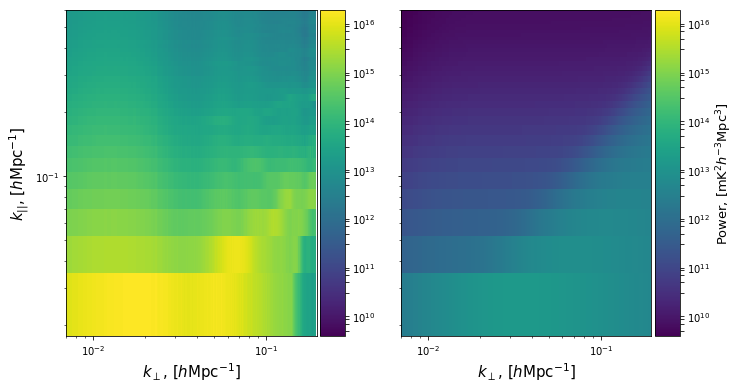

ValueError: values must all be positive

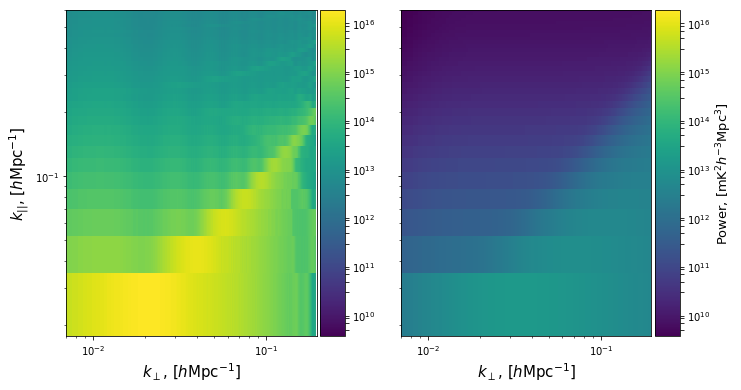

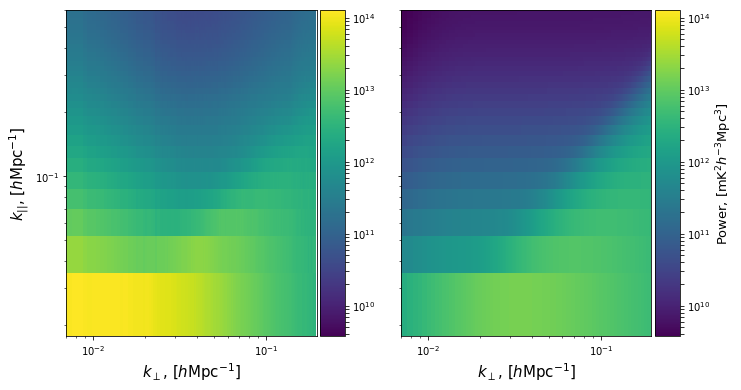

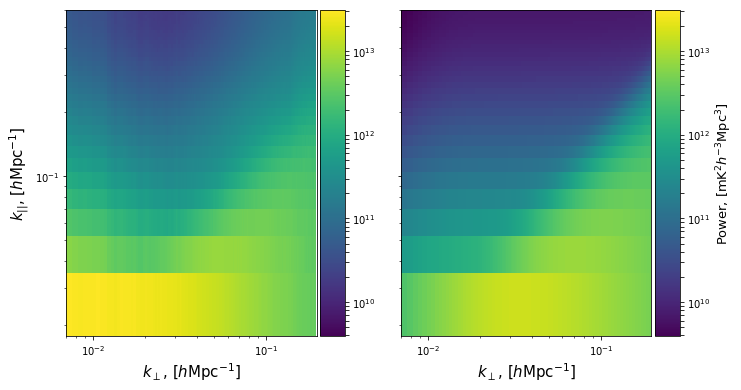

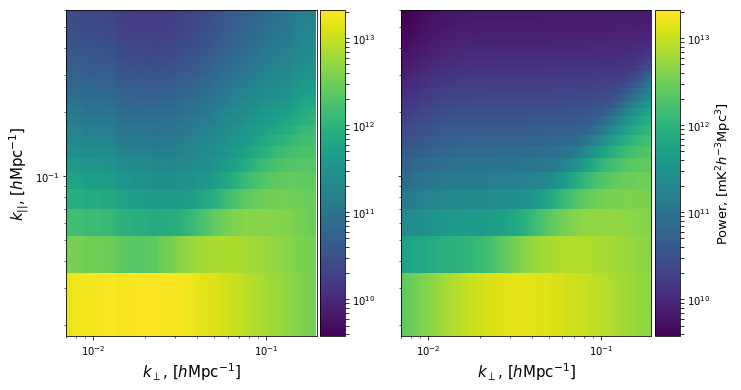

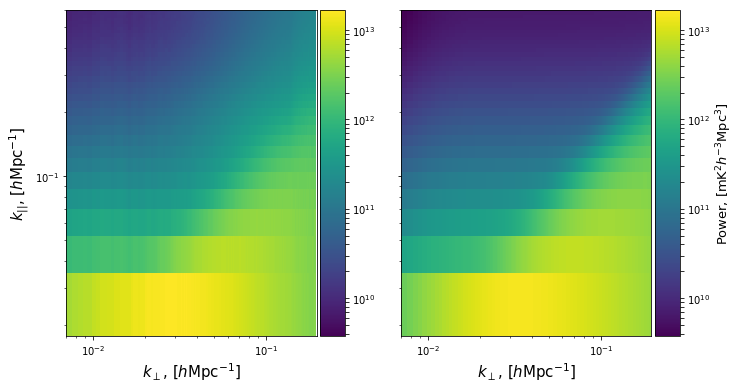

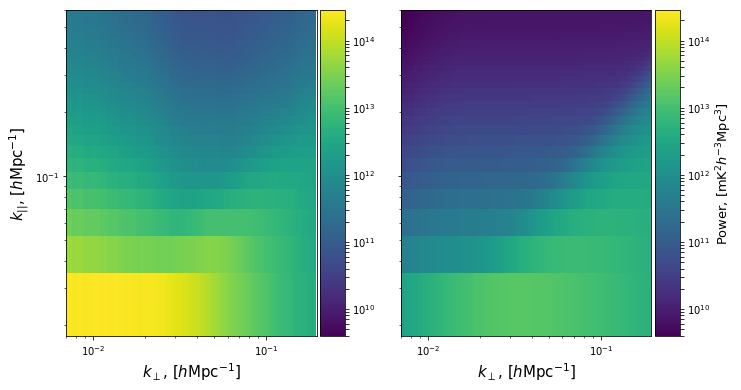

In [7]:
mask = kperp.value>7e-3
for i,tag in enumerate(ps.keys()):
    try:
        fig,ax = plot_2D_PS_compare(ps[tag][:,mask],pps[tag][:,mask],kperp[mask],kpar,interp="nearest")
        fig.savefig("comparison_%s.png"%tag)
    except Exception as e:
        print e

Data has no positive values, and therefore can not be log-scaled.


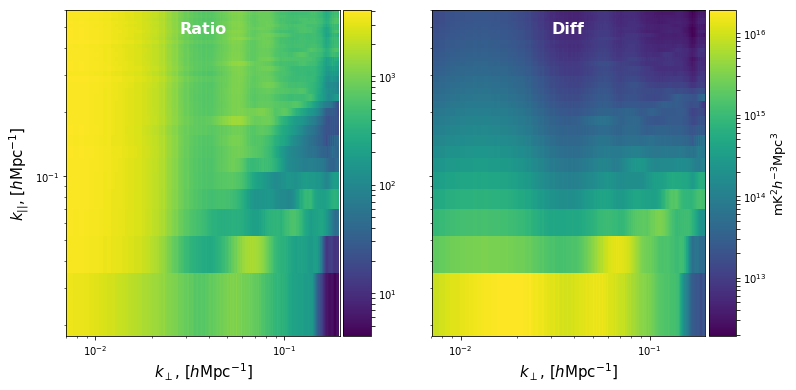

ValueError: values must all be positive

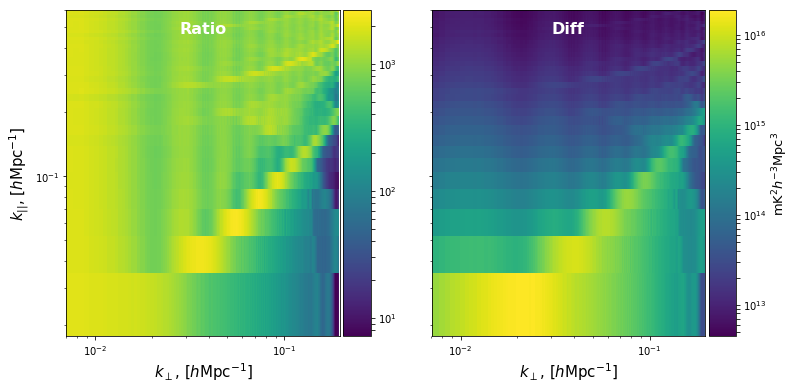

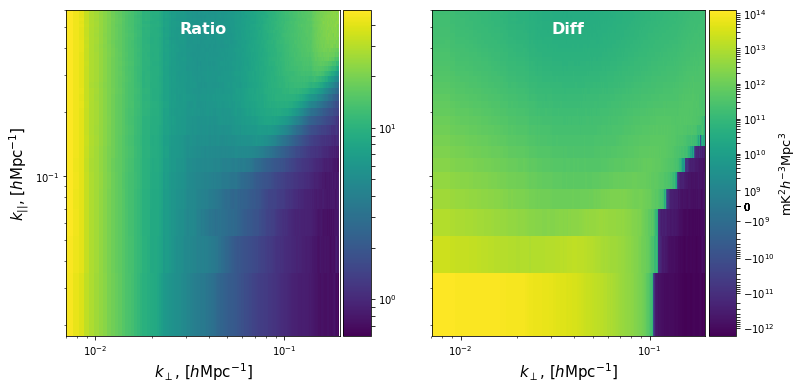

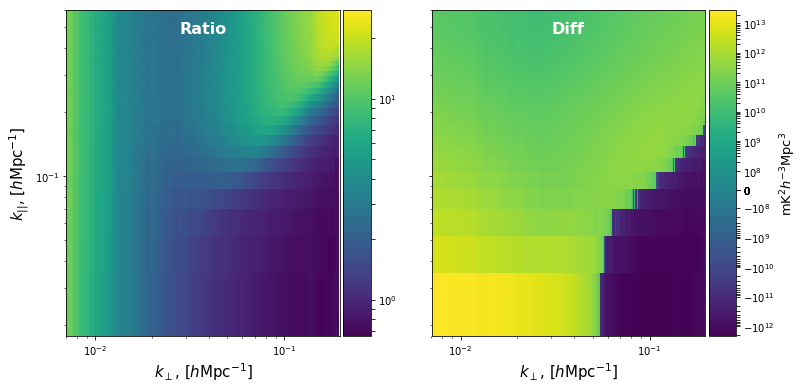

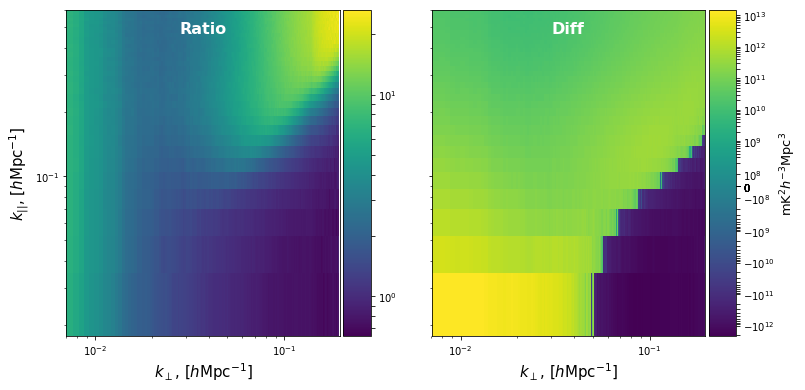

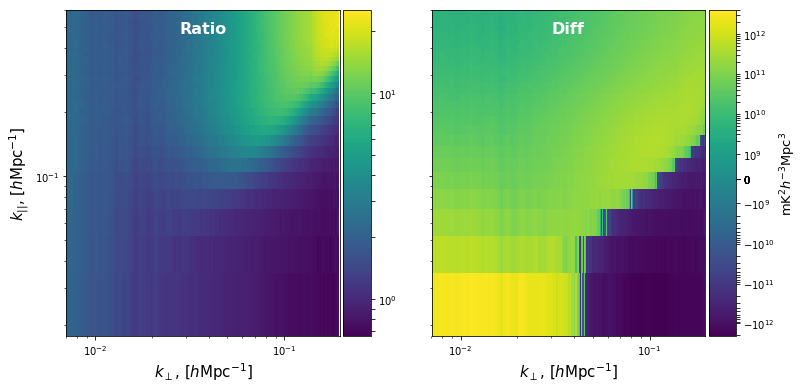

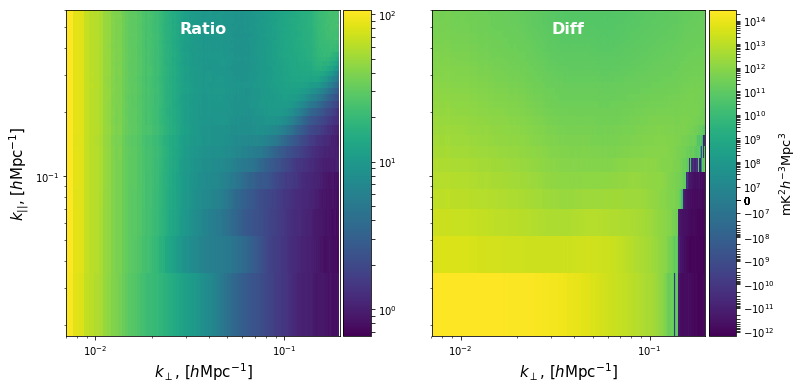

In [8]:
for i,tag in enumerate(ps.keys()):
    try:
        fig,ax = plot_2D_PS_ratio_diff(ps[tag][:,mask],pps[tag][:,mask],kperp[mask],kpar,interp="none")
        fig.savefig("ratio_diff_%s.png"%tag)
    except Exception as e:
        print e
        
# fig,ax = plot_2D_PS_ratio_diff(ps[:,mask],pps[:,mask],kperp[mask],kpar)
# fig.savefig("ratio_diff_initial.png")

In [11]:
np.outer(np.linspace(0,1,10),np.linspace(0,1,16).reshape((4,4))).shape

(10, 16)

In [17]:
a = np.repeat(np.linspace(0,1,16).reshape((4,4)),5).reshape((4,4,5))

In [18]:
a[:,:,0]

array([[ 0.        ,  0.06666667,  0.13333333,  0.2       ],
       [ 0.26666667,  0.33333333,  0.4       ,  0.46666667],
       [ 0.53333333,  0.6       ,  0.66666667,  0.73333333],
       [ 0.8       ,  0.86666667,  0.93333333,  1.        ]])

In [19]:
(1,)+(2,)

(1, 2)

In [17]:
from scipy.special import j0, i0, factorial

In [22]:
i0(50)*np.exp(-50**2)

0.0

In [20]:
np.sum(1./factorial(np.arange(20))**2)

2.2795853023360673